In [2]:
import numpy as np
import pandas as pd
import pymysql
import configparser
from decimal import Decimal
import json

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 连接数据库

In [3]:

def getConn():
    config = configparser.ConfigParser()
    config.read('config.ini', encoding='utf8')
    db_url = config['base_config']['host']
    db_port = config['base_config']['port']
    db_username = config['base_config']['username']
    db_password = config['base_config']['password']
    db_name = config['base_config']['basename']
    return pymysql.connect(host=db_url,
                           port=int(db_port),
                           user=db_username,
                           password=db_password,
                           db=db_name,
                           charset='utf8mb4')

In [4]:
conn = getConn()

In [5]:
# 读取 cmc  top100
data = pd.DataFrame()
for year in range(2018, 2025):
    sql = f'''
        SELECT symbol, date_time_ymd, tvl_ratio, market_cap, price
        FROM pv_allcoin_raw_data_daily_cmc_{year}
        WHERE id NOT IN (6801, 28167, 28040, 28043, 25967, 27929)
        AND tags NOT LIKE '%stablecoin%' and cmc_rank<=100;
        '''
    cs = conn.cursor()
    cs.execute(sql)
    res = cs.fetchall()
    df = pd.DataFrame(res, columns=['symbol', 'date_time_ymd', 'tvl_ratio', 'market_cap', 'price'])
    data = pd.concat([data, df], ignore_index=True)


In [6]:
tmp_data = data[(data['symbol']=='BTC') | (data['symbol']=='ETH')]
tmp_data.reset_index(inplace=True, drop=True)
tmp_data

,symbol,date_time_ymd,tvl_ratio,market_cap,price
0,BTC,2018-09-10,NaN,1.092556e+11,6329.700000
1,ETH,2018-09-10,NaN,2.007852e+10,197.079000
2,BTC,2018-09-11,NaN,1.091199e+11,6321.200000
3,ETH,2018-09-11,NaN,1.885838e+10,185.066000
4,BTC,2018-09-12,NaN,1.096615e+11,6351.800000
...,...,...,...,...,...
4605,ETH,2024-12-30,NaN,4.058420e+11,3368.858286
4606,BTC,2024-12-31,NaN,1.820149e+12,91911.452573
4607,ETH,2024-12-31,NaN,3.997448e+11,3318.189256
4608,BTC,2024-12-29,NaN,1.931442e+12,97415.738925


In [7]:
data.dropna(inplace=True)
data = data[data['tvl_ratio'] >= 0]
data.reset_index(inplace=True, drop=True)

In [8]:
# TVL Ratio = 市值（Market Cap）/ 总锁仓价值（TVL）
data['tvl'] = data['market_cap'] / data['tvl_ratio']

In [9]:
data = pd.concat([data, tmp_data], axis=0)
data.reset_index(inplace=True, drop=True)

In [11]:
data.to_csv('tvl-data.csv', index=False)

In [12]:
tv_data = pd.read_csv('tvl-data.csv')

In [23]:
data = tv_data[(tv_data['symbol']!='BTC') & (tv_data['symbol']!='ETH')][['date_time_ymd', 'market_cap', 'tvl']].groupby('date_time_ymd').sum().reset_index()
data['BTC_mcap'] = tv_data[tv_data['symbol']=='BTC']['market_cap'].reset_index(drop=True)
data['BTC_price'] = tv_data[tv_data['symbol']=='BTC']['price'].reset_index(drop=True)
data['ETH_mcap'] = tv_data[tv_data['symbol']=='ETH']['market_cap'].reset_index(drop=True)

In [27]:
data.head()

,date_time_ymd,market_cap,tvl,BTC_mcap,BTC_price,ETH_mcap
0,2023-01-28,1.239341e+10,3.696697e+10,1.092556e+11,6329.70,2.007852e+10
1,2023-01-29,1.215085e+10,3.703681e+10,1.091199e+11,6321.20,1.885838e+10
2,2023-01-30,1.243709e+10,3.703681e+10,1.096615e+11,6351.80,1.868532e+10
3,2023-01-31,1.188271e+10,3.745944e+10,1.125310e+11,6517.31,2.154578e+10
4,2023-02-01,1.187398e+10,3.661555e+10,1.124625e+11,6512.71,2.159037e+10


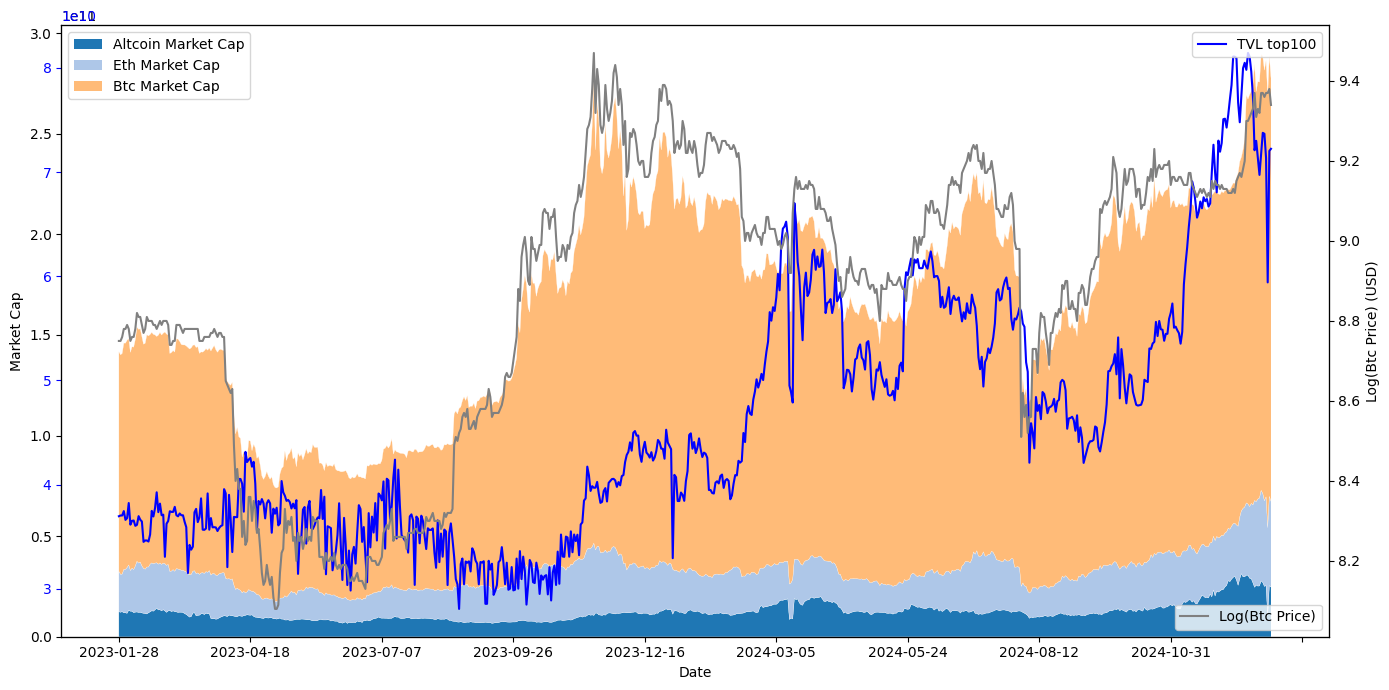

In [47]:
fig, ax1 = plt.subplots(figsize=(14, 7))
market_caps = [
    data["market_cap"],
    data["ETH_mcap"],
    data["BTC_mcap"],
]
labels = ['Altcoin Market Cap', 'Eth Market Cap', 'Btc Market Cap',]
colors = ['#1f77b4', '#aec7e8', '#ffbb78']
stacks = ax1.stackplot(data["date_time_ymd"], *market_caps, labels=labels, colors=colors)
cum_mc = 0
for mc in market_caps:
    cum_mc+=mc
    ax1.plot(data["date_time_ymd"], cum_mc, color="white", linewidth=0.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Market Cap')
ax1.legend(loc='upper left')
# 设置x轴的时间间隔
locator = ticker.MaxNLocator(10)  # 显示10个刻度
ax1.xaxis.set_major_locator(locator)

ax2 = ax1.twinx()
ax2.plot(data['date_time_ymd'], data['tvl'], color='blue', label='TVL top100')
ax2.tick_params(axis='y', colors='blue')
ax2.legend(loc='upper right')

ax3 = ax2.twinx()
ax3.plot(data["date_time_ymd"], round(np.log(data["BTC_price"]),2), color='gray', label='Log(Btc Price)')
ax3.set_ylabel('Log(Btc Price) (USD)')
ax3.legend(loc='lower right')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.savefig("tvl_MarketCap.png")
plt.show()